In [255]:
import numpy as np # type: ignore
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import yfinance as yf # type: ignore

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# Load financial data

In [256]:
data = yf.download('AAPL')

[*********************100%***********************]  1 of 1 completed


In [257]:
data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
1980-12-12,0.098834,0.128348,0.128906,0.128348,0.128348,469033600
1980-12-15,0.093678,0.121652,0.122210,0.121652,0.122210,175884800
1980-12-16,0.086802,0.112723,0.113281,0.112723,0.113281,105728000
1980-12-17,0.088951,0.115513,0.116071,0.115513,0.115513,86441600
1980-12-18,0.091530,0.118862,0.119420,0.118862,0.118862,73449600


In [258]:
X = data.to_numpy()
X.shape

(11094, 6)

In [259]:
def create_sequence(data: np.ndarray, seq_len: int = 8, target_sequence: bool = False) -> tuple[np.ndarray, np.ndarray]:
    X = []
    y = []
    for i in range(len(data) - seq_len - 1):
        X.append(data[i:i+seq_len])
        if target_sequence:
            y.append(data[(i+1):(i+1+seq_len)])
        else:
            y.append(data[i+seq_len])
    return np.array(X), np.array(y)

# Split and scale

In [260]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler_X = StandardScaler()
#scaler_X = MinMaxScaler(feature_range=(0, 1))

X_train, X_test = train_test_split(X, test_size=0.2)

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

print(f'Train: {X_train.shape}, Test: {X_test.shape}')

Train: (8875, 6), Test: (2219, 6)


# Create sequences

In [261]:
X_train, y_train = create_sequence(X_train, seq_len=10)
X_test, y_test = create_sequence(X_test, seq_len=7)

print(f'X, y_train: {X_train.shape} {y_train.shape}')
print(f'X, y_test: {X_test.shape} {y_test.shape}')

X, y_train: (8864, 10, 6) (8864, 6)
X, y_test: (2211, 7, 6) (2211, 6)


In [262]:
#y_train, y_test = y_train.reshape(-1, 1, 6), y_test.reshape(-1, 1, 6)
#print(f'y_train, y_test: {y_train.shape}, {y_test.shape}')

# Custom dataset

In [263]:
class StockDataset(Dataset):

    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        """
        Returns the number of samples in the dataset.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retrieves the data and label at the given index.
        
        Args:
            idx (int): The index of the sample to retrieve.
        
        Returns:
            tuple: (data, label)
        """
        sample = self.data[idx]
        target = self.targets[idx]
        return sample, target

# Data preparation

In [264]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

X_train, X_test, y_train, y_test = torch.Tensor(X_train), torch.Tensor(X_test), torch.Tensor(y_train), torch.Tensor(y_test)
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

In [265]:
batch_size = 64

dataset_train = StockDataset(X_train, y_train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)

dataset_test = StockDataset(X_test, y_test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [266]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=6, dropout=0.1):
        super(LSTMModel, self).__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        
        # Define the Transformer model
        self.lstm = nn.LSTM(input_size=input_dim, 
                            hidden_size=hidden_dim, 
                            num_layers=num_layers, 
                            dropout=dropout,
                            batch_first=True)
        
        # Output layer (linear transformation from hidden_dim to output_dim)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h_0 = torch.zeros(
            self.num_layers, x.size(0), self.hidden_dim).to(device)
        c_0 = torch.zeros(
            self.num_layers, x.size(0), self.hidden_dim).to(device)
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        #print(f'hout: {h_out.shape}')
        h_out = h_out[-1, :, :]#h_out.view(-1, self.hidden_dim)
        out = self.fc_out(h_out)
        
        return out

In [267]:
n_features = 6  # Number of financial indicators

model = LSTMModel(input_dim=n_features, output_dim=n_features, hidden_dim=128, num_layers=3, dropout=0.3)
model = model.to(device)

In [268]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.train()

for epoch in range(100):

    epoch_loss = 0

    for data, target in dataloader_train:
        output = model(data)
        #print(f'output shae: {output.shape}')
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    print(f"Epoch: {epoch+1}, Loss: {epoch_loss / len(dataloader_train)}")

Epoch: 1, Loss: 1.0019244553802682
Epoch: 2, Loss: 1.0014822931169607
Epoch: 3, Loss: 1.0014180230150977
Epoch: 4, Loss: 1.0013703686727895
Epoch: 5, Loss: 1.001332090912963
Epoch: 6, Loss: 1.0013260118824114
Epoch: 7, Loss: 1.001292543659965
Epoch: 8, Loss: 1.0013156393877893
Epoch: 9, Loss: 1.0012685774470405
Epoch: 10, Loss: 1.0012738117211157
Epoch: 11, Loss: 1.0012632739200866
Epoch: 12, Loss: 1.0012832123169797
Epoch: 13, Loss: 1.001244543696479
Epoch: 14, Loss: 1.0012080832351027
Epoch: 15, Loss: 1.0012064944925925
Epoch: 16, Loss: 1.001270151609997
Epoch: 17, Loss: 1.0011175030427013
Epoch: 18, Loss: 1.0010233302768186
Epoch: 19, Loss: 1.0008878800079977
Epoch: 20, Loss: 1.0008297622632638
Epoch: 21, Loss: 1.0008177620043857
Epoch: 22, Loss: 1.0000726936532438
Epoch: 23, Loss: 1.0003028670660883
Epoch: 24, Loss: 0.9989815547311907
Epoch: 25, Loss: 0.9977351682220431
Epoch: 26, Loss: 0.9957187049251666
Epoch: 27, Loss: 0.9949471828320043
Epoch: 28, Loss: 0.9909128218674831
Epoch

In [269]:
model.eval()

with torch.no_grad():

    val_output = model(X_test)
    val_loss = criterion(val_output, y_test)
    print(f"Validation Loss: {val_loss.item()}")

Validation Loss: 1.468685269355774


In [270]:
true_unscaled = scaler_X.inverse_transform(y_test.reshape(-1, 6).cpu())[:20]
predicted_unscaled = scaler_X.inverse_transform(val_output.reshape(-1, 6).cpu())[:20]
print(f'Shapes: {true_unscaled.shape}, {predicted_unscaled.shape}')

Shapes: (20, 6), (20, 6)


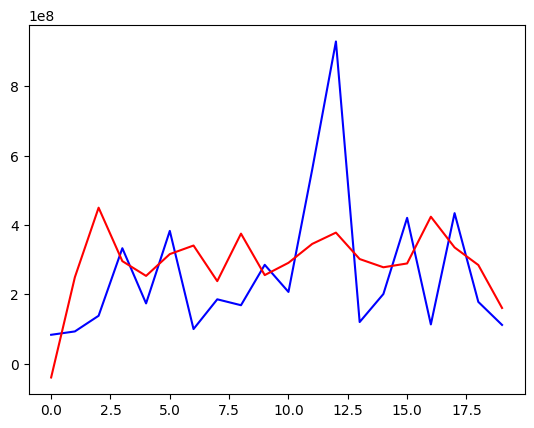

In [272]:
x = [i for i in range(len(true_unscaled))]
plt.plot(x, true_unscaled[:, 5], color='blue')
plt.plot(x,predicted_unscaled[:, 5], color='red')
plt.show()